In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt
from Channel_Generation_6_S1 import Channel_Generation_6 as GC
from Optimisation_Algorithm import Optimisation as opt
from BCD_Code_3 import BCD as BCD3
# import matlab.engine
# eng = matlab.engine.start_matlab()
##########################################
# Set simulation parameters 
max_iter=10
K= 4 #No. of users
noise = -105  #dbm
realisations = 1000 #no of channel realisations
noise = 10 ** (noise/10 - 3) #linear scale
N = 100                      #no of elements in IRS
M = 4                     #no of Tx. Antennas
X2 = 2  # 2 users selected
X3 = 3  # 3 users selected
power_dBm =  np.array(range(-10, 41, 2))
Power_w = 10 ** (power_dBm/10  ) * 0.001
P_len = len(Power_w)
W_vec = np.ones(K) # weight of users, MATLAB.
############################################
# Random beamforming matrix with overall power 1
W_1 =  np.random.rand(M,K) + 1j * np.random.rand(M,K)
W = np.zeros((M,K), dtype='complex')    # initialising the BF vectors
for k in range(K):
  # When K users are served power is equally split among users
  # Total transmit power of 1
  W[:,k] = np.sqrt(1/K) * W_1[:,k] / np.linalg.norm(W_1[:,k])
####################################################################
# Initialising the phases at IRS randomly
phase0 = np.random.rand(N)*2*np.pi
v = np.exp(1j*phase0)
Theta = np.diag(v)
##########################
# Generate the channel realizations and the equivalent channel with random RIS phases
Hr= np.zeros(( realisations, K, N), dtype= 'complex')
Hd= np.zeros(( realisations, K, M), dtype= 'complex')
H_m_s1= np.zeros(( realisations, K, M), dtype= 'complex')
G= np.zeros(( realisations, N, M), dtype= 'complex')
H_eq = np.zeros((realisations,K,M) ,dtype='complex')   # Equivalent Channel  
NU_matrix = np.zeros(realisations,dtype=int)
for j in range(realisations):
    CG= GC(K, M, N)
    Hd2, Hr2, G2, NU_matrix[j]= CG.Channels()
    Hd[j, :, :]= Hd2.T
    Hr[j, :, :]= Hr2.T
    G[j, :, :]= G2
    H_eq[j,:,:] = Hd[j,:,:] +   Hr[j,:,:] @ Theta @ G[j,:,:]


In [2]:
#######################################################  NCC Paper Code ##########################################################
# Initialize matrices to store the results -- sum rates
sr_ao = np.zeros((P_len,realisations,K)) # single user transmission with AO 
r_1 = np.zeros((P_len,realisations))     # max rate among the single user tranmission schemes
r_1_rnd = np.zeros((P_len,realisations))
r_1_rnd2 = np.zeros((P_len,realisations))
sr_2 = np.zeros((P_len,realisations))    # sum rates for 2 user transmission scheme SUS selection + best user phase
sr_2_rnd = np.zeros((P_len,realisations)) # sum rates for 2 user transmission scheme with SUS selection + random phase
sr_3 = np.zeros((P_len,realisations))     # sum rates for 3 user transmission scheme SUS selection + best user phase
sr_3_rnd = np.zeros((P_len,realisations)) # sum rates for 3 user transmission scheme SUS selection + random phase
sr_4 = np.zeros((P_len,realisations))     # sum rates for 4 user ZF + best user phase  
sr_4_rnd = np.zeros((P_len, realisations)) # sum rates for 4 user ZF + random phase
bcd_rates=np.zeros((P_len,realisations))
index = np.zeros((P_len,realisations))
dynamic_rate=np.zeros((P_len,realisations)) 
bcd_all = np.zeros((P_len,realisations))
bcd_all2 = np.zeros((P_len,realisations))
bcd_all3 = np.zeros((P_len,realisations))
bcd_final = np.zeros((P_len,realisations))
weights_K = np.ones(K)
sr_wmmse2 = np.zeros((P_len,realisations))
sr_wmmse3 = np.zeros((P_len,realisations))
sr_wmmse4 = np.zeros((P_len,realisations))
# variables to store mean sum rates
list_1=[]
list_2=[]
list_3=[]
list_4=[]
list_5=[]
list_6=[]
list_7=[]
list_8=[]
list_rates=[]
list_BF=[]
rates_matlab = np.zeros((K,P_len))
wsr_matlab = np.zeros((P_len,realisations))
DR_mean=[]
counter = np.zeros(K)
cnt_matrix = np.zeros((len(Power_w),K))
list_wmmse2 = []
list_wmmse3 =[]
for p in range(P_len):
    opt_AO = opt(K,M,N,Power_w[p],K,noise)
    opt_1 = opt(K,M,N,Power_w[p],1,noise)
    opt_2 = opt(K,M,N,Power_w[p],2,noise)
    opt_3 = opt(K,M,N,Power_w[p],3,noise)
   
    bcd_K = BCD3(M,K,N,Power_w[p],weights_K,True, max_iter)
    

    for j in range(realisations):
        # find rates for single user transmission to each user k
        for k in range(K):
            w_ao, Theta_ao = opt_AO.AO_Single_User(k, Hd[j,:, :], Hr[j,:, :], G[j,:,:])
            H_ao = Hd[j,:,:] + Hr[j,:,:] @ Theta_ao @ G[j,:,:]
            sr_ao[p,j,k] = opt_AO.MRT_BF_Single_serving(H_ao,w_ao,k)
            #w_ao_list.append(w_ao)
        best_index = np.argmax(sr_ao[p,j,:]) # best user index
        
        T2 = list(sr_ao[p,j,:])
        T2 = [x for x in T2 if x != T2[best_index]]
        sus_index = np.argmax(T2) # second best user index
        r_1[p,j] = np.max(sr_ao[p,j,:])
        #align the RIS to the best user index
        w_bi, Theta_bi = opt_AO.AO_Single_User(best_index, Hd[j,:, :], Hr[j,:, :], G[j,:,:])
        H = Hd[j,:,:] + Hr[j,:,:] @ Theta_bi @ G[j,:,:]
        ####################################
        ####################################
        # align the RIS to 2nd best user_index
        w_sus, Theta_sus = opt_AO.AO_Single_User(sus_index, Hd[j,:, :], Hr[j,:, :], G[j,:,:]) 
        ################################
        rnd_index = random.randint(0,3)
        r_1_rnd[p,j] = opt_AO.MRT_BF_Single_serving(H_eq[j,:,:],W,rnd_index)
        r_1_rnd2[p,j] = opt_AO.MRT_BF_Single_serving(H_eq[j,:,:],w_bi,rnd_index)
        ################################
        # SUS selection of users
        # now we perform sus for 2 users.
        sus_or_bi2 = 0
        S2 = opt_2.SUS_Algo(H,1)
        sr_2_rnd[p,j],_ = opt_2.Rate_User_Selection2(H_eq[j,S2,:],S2)
        
        #if S2.any() == best_index:
            
            # channels for selected users.
        H2 = Hd[j,S2,:] + Hr[j,S2,:] @ Theta_bi @ G[j,:,:]
        sr_2[p,j],W2 = opt_2.Rate_User_Selection2(H2,S2)
        sr_wmmse2[p,j],w2_mmse = opt_2.Rate_US_MMSE(H2,S2)
        # else:   
        #     H2 = Hd[j,S2,:] + Hr[j,S2,:] @ Theta_sus @ G[j,:,:]
        #     sr_2[p,j],W2 = opt_2.Rate_User_Selection2(H2,S2)
        #     sr_wmmse2[p,j],w2_mmse = opt_2.Rate_US_MMSE(H2,S2)
        #     sus_or_bi2 = 1
        
        # now we perform sus for 3 users.
        sus_or_bi3 = 0
        S3 = opt_3.SUS_Algo(H,1)
        
        sr_3_rnd[p,j],_ = opt_3.Rate_User_Selection2(H_eq[j,S3,:],S3)
        #if S3.any() == best_index:
            
            # channels for selected users.
        H3 = Hd[j,S3,:] + Hr[j,S3,:] @ Theta_bi @ G[j,:,:]
        sr_3[p,j],W3 = opt_3.Rate_User_Selection2(H3,S3)
        sr_wmmse3[p,j],w3_mmse = opt_3.Rate_US_MMSE(H3,S3)
        # else:
        #     H3 = Hd[j,S3,:] + Hr[j,S3,:] @ Theta_sus @ G[j,:,:]
        #     sr_3[p,j],W3 = opt_3.Rate_User_Selection2(H3,S3)
        #     sr_wmmse3[p,j],w3_mmse = opt_3.Rate_US_MMSE(H3,S3)
        #     sus_or_bi3 = 1
         
        # now we perform sus for all K users.
        
        sr_4[p,j] = opt_AO.ZF_BF(H)
        W4 = np.linalg.pinv(H)
        W4 = W4/(np.linalg.norm(W4, axis=0))
        W4 = np.sqrt(Power_w[p]/K) * W4
        # now we perform sus for all K users but random phases.
        sr_4_rnd[p,j] = opt_AO.ZF_BF(H_eq[j,:,:])
        counter
        # dynamic zf
        list_rates += [r_1[p,j],sr_2[p,j], sr_3[p,j],sr_4[p,j]]
        list_BF += [w_bi,W2,W3,W4]
        index[p,j] = np.argmax(list_rates)
        ind = int(index[p,j])
        #print(ind)
        dynamic_rate[p,j]=(np.max(list_rates))
        #print("list rates:",list_rates)
        
        
        #print("ind:",ind)
        # print("dynamic sum rate:",dynamic_rate[p,j])
        list_rates=[]
        
        W_MRT = np.conj(H).T
        W_MRT = W_MRT/(np.linalg.norm(W_MRT,axis=0))
        W_MRT = np.sqrt(Power_w[p]/K) * W_MRT
        # All BCD
        W_bcd = list_BF[ind]
        
        Theta_init = Theta_bi

        if ind == 1 and sus_or_bi2 == 1:
            Theta_init = Theta_sus

        if ind == 2 and sus_or_bi3 == 1:
            Theta_init = Theta_sus
            
        _,bcd_all[p,j],_ = bcd_K.alternating_optimization((Hd[j,:,:]/np.sqrt(noise)),(Hr[j,:,:]/np.sqrt(noise)),G[j,:,:],Theta_init,W_bcd)
        #_,bcd_all2[p,j],_ = bcd_K.alternating_optimization((Hd[j,:,:]/np.sqrt(noise)),(Hr[j,:,:]/np.sqrt(noise)),G[j,:,:],Theta_init,W4)
        #_,bcd_all3[p,j],_ = bcd_K.alternating_optimization((Hd[j,:,:]/np.sqrt(noise)),(Hr[j,:,:]/np.sqrt(noise)),G[j,:,:],Theta_init,W_MRT)
        bcd_final[p,j] = bcd_all[p,j] #np.max([bcd_all[p,j],bcd_all2[p,j],bcd_all3[p,j]])
        #print("p:",p,"j:",j)
        list_BF=[]


         # matlab code:
        #print("size H=",H.shape, Power_w[p],W_vec)
        H_m_s1[j,:,:] = Hd[j,:,:]/np.sqrt(noise) + Hr[j,:,:]/np.sqrt(noise) @ Theta_init @ G[j,:,:]
        np.save("chan_s1_mat",H_m_s1)
        # _,wsr_matlab[p,j],_,_= eng.miso_bc_wsrmax(H_m,Power_w[p],W_vec)
        #eng.quit()
  
    # now averaging over the realisations.
    list_1 = np.mean(np.max(sr_ao,axis=2),axis=1) # 1 user served
    list_1_rnd = np.mean(r_1_rnd,axis=1)
    list_1_rnd2 = np.mean(r_1_rnd2,axis=1)
    list_2 = np.mean(sr_2,axis=1) # 2 users served
    list_3 = np.mean(sr_3,axis=1) # 3 users served
    list_4 = np.mean(sr_4,axis=1) # 4 users served
    list_5 = np.mean(sr_4_rnd,axis=1) # 4 users served (random phases)
    list_7 = np.mean(sr_2_rnd,axis=1) # 2 users(random phases).
    list_8 = np.mean(sr_3_rnd,axis=1) # 3 users(random phases).
    DR_mean= np.mean(dynamic_rate,axis=1) # dynamic zf 
    #Dyn_bcd = np.mean(bcd_rates,axis=1)
    list_bcd = np.mean(bcd_final,axis=1)
    # all_bcd2 = np.mean(bcd_all2,axis=1)
    # all_bcd3 = np.mean(bcd_all3,axis=1)
    # wsr_dpc = np.mean(wsr_matlab,axis=1)
    # eng.quit()
    list_wmmse2 = np.mean(sr_wmmse2,axis=1)
    list_wmmse3 = np.mean(sr_wmmse3,axis=1)

In [3]:
print(power_dBm + Power_w)

[-9.99990000e+00 -7.99984151e+00 -5.99974881e+00 -3.99960189e+00
 -1.99936904e+00  1.00000000e-03  2.00158489e+00  4.00251189e+00
  6.00398107e+00  8.00630957e+00  1.00100000e+01  1.20158489e+01
  1.40251189e+01  1.60398107e+01  1.80630957e+01  2.01000000e+01
  2.21584893e+01  2.42511886e+01  2.63981072e+01  2.86309573e+01
  3.10000000e+01  3.35848932e+01  3.65118864e+01  3.99810717e+01
  4.43095734e+01  5.00000000e+01]


In [4]:
np.save("channelarr_final",H_m_s1)

In [25]:
from scipy.io import savemat
savemat("ch_loss0dB.mat", {"channel_matrix": H_m_s1})

Simulations for Without RIS:

In [6]:
rw_1 = np.zeros((P_len,realisations))     # max rate among the single user tranmission schemes
r1w = np.zeros((P_len,realisations,K)) # single user transmission.
sr2_w = np.zeros((P_len, realisations)) # sum rate for 2 users without ris
sr3_w = np.zeros((P_len, realisations)) # sum rate for 3 users without ris
sr4_w = np.zeros((P_len, realisations)) # sum rate for 4 users without ris
rate_w1=[]
rate_w2=[]
rate_w3=[]
rate_w4=[]
rate_w_dynamic=[]
for p in range(P_len):
    opt_1 = opt(K,M,N,Power_w[p],1,noise)
    opt_2 = opt(K,M,N,Power_w[p],2,noise)
    opt_3 = opt(K,M,N,Power_w[p],3,noise)
    opt_K = opt(K,M,N,Power_w[p],K,noise)

    for j in range(realisations):
        H1 = Hd[j,:,:]
        #print(H1)         
        W1 = np.conj(H1).T/(np.linalg.norm(H1))
        #print(W1)
        W1 = np.sqrt(Power_w[p]) * W1
        #Transmit to 1 User:
        for k in range(K):  
            r1w[p,j,k] = opt_K.MRT_BF_Single_serving(H1,W1,k)
        rw_1[p,j] = np.random.choice(r1w[p,j,:])  # transmit to user with max rate.

        # Transmit to 2 users:
        S2 = opt_2.SUS_Algo(H1,1)
        sr2_w[p,j],_ = opt_2.Rate_User_Selection2(H1[S2,:],S2)

        # Transmit to 3 users:
        S3 = opt_3.SUS_Algo(H1,1)
        sr3_w[p,j],_ = opt_3.Rate_User_Selection2(H1[S3,:],S3)
        #print(S3)
        # Transmit to 4 users:
        S4 = range(K)
        sr4_w[p,j] = opt_K.ZF_BF(H1[:,:])

    rate_w1 = np.mean(rw_1,axis=1)
    rate_w2 = np.mean(sr2_w,axis=1)
    rate_w3 = np.mean(sr3_w,axis=1)
    rate_w4 = np.mean(sr4_w,axis=1)
    #rate_w_dynamic = np.max(rate_w1,rate_w2,rate_w3,rate_w4)

print("rate_w1:\n",rate_w1)
print("rate_w2:\n",rate_w2)       
print("rate_w3:\n",rate_w3)
print("rate_w4:\n",rate_w4)
 

rate_w1:
 [ 0.22632148  0.32199223  0.45522936  0.66702186  0.93334193  1.20646873
  1.61558031  2.02108812  2.57801476  3.04159511  3.65685809  4.24712316
  4.88961899  5.48161367  6.19370319  6.82958261  7.47798353  8.14429878
  8.77079874  9.48093156 10.16577659 10.7303837  11.45498069 12.11711516
 12.74398531 13.44019104]
rate_w2:
 [ 0.76677881  1.12879103  1.61816097  2.24972016  3.02637253  3.93818233
  4.96549111  6.08424967  7.27097562  8.50577787  9.77336116 11.06272155
 12.36629284 13.67902769 14.99762546 16.31995546 17.64465365 18.9708514
 20.29799746 21.62574271 22.95386637 24.28222893 25.61074227 26.93935077
 28.26801932 29.59672576]
rate_w3:
 [ 0.49305489  0.75117914  1.12501666  1.64848289  2.35287077  3.26001694
  4.37667565  5.69275401  7.18425478  8.81936155 10.56491512 12.39113715
 14.27391935 16.19514533 18.14191029 20.10536449 22.07959921 24.06074226
 26.0462884  28.03463088 30.02474511 32.0159802  34.00792371 36.00031468
 37.99298817 39.98583999]
rate_w4:
 [ 0.198

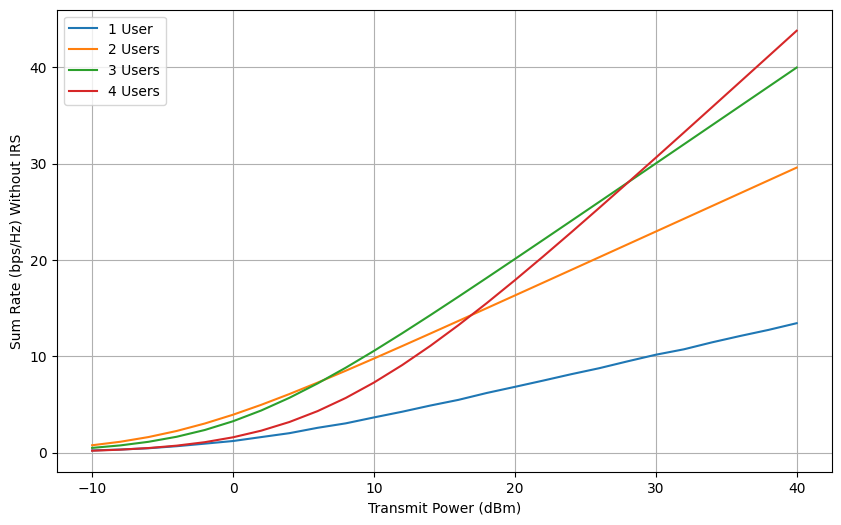

In [7]:
plt.figure(figsize=(10,6))
plt.plot(power_dBm,rate_w1, label='1 User')
plt.plot(power_dBm,rate_w2, label='2 Users')
plt.plot(power_dBm,rate_w3, label='3 Users')
plt.plot(power_dBm,rate_w4, label='4 Users')

plt.xlabel('Transmit Power (dBm)')
plt.ylabel('Sum Rate (bps/Hz) Without IRS')
plt.legend()    
plt.grid()
#plt.savefig("s1fig2", dpi=1200, bbox_inches="tight")
plt.show()

In [8]:
dpc_rate =[2.1915
,     2.8860
,     3.6943
,     4.6534
,     5.8009
,     7.1481
,     8.7008
,    10.4571
,    12.3968
,    14.4973
,    16.7324
,    19.0752
,    21.5030
,    23.9933
,    26.5335
,    29.1134
,    31.7150
,    34.3343
,    36.9671
,    39.6083
,    42.2564
,    44.9058
,    47.5595
,    50.2124
,    52.8682
,    55.5238]


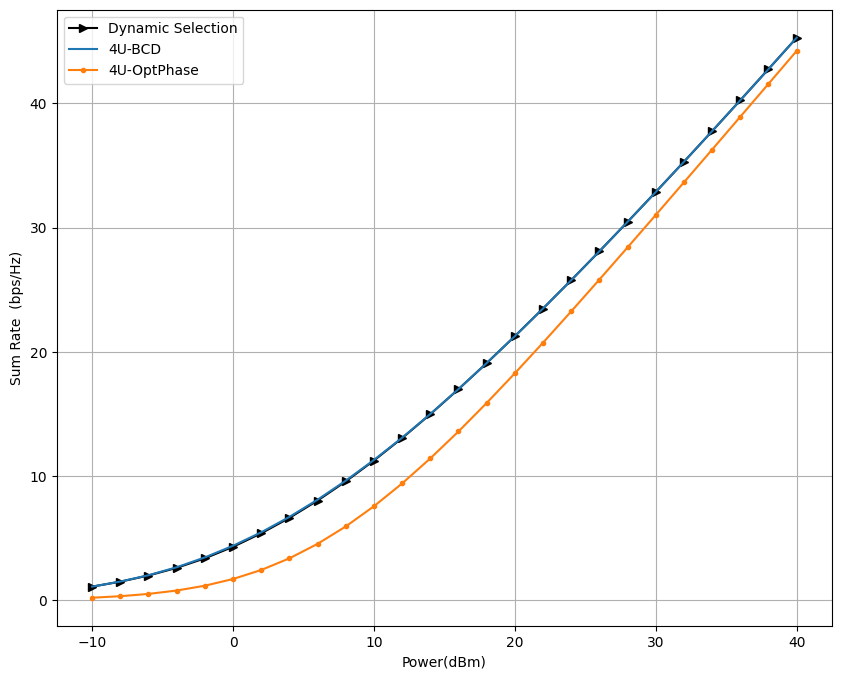

In [9]:
plt.figure(figsize=(10,8))

plt.plot(power_dBm, DR_mean, marker='>',label='Dynamic Selection', color='black')
plt.plot(power_dBm, list_bcd,label='4U-BCD')
plt.plot(power_dBm, list_4, marker='.',label='4U-OptPhase')
#plt.plot(power_dBm, dpc_rate,marker='*',label='4U-SumCapacity')
plt.xlabel('Power(dBm)')

plt.ylabel('Sum Rate  (bps/Hz)')
plt.grid()
plt.legend()
plt.savefig("s2_fig4(thesis)", dpi=1200, bbox_inches="tight")
plt.show()

In [10]:
print("Dynamic rate=\n", DR_mean)
print("BCD all users=\n", list_bcd)
print("4U-OptPhase=\n", list_4)
import matplotlib.pyplot as plt


Dynamic rate=
 [ 1.11448814  1.51438273  2.00989533  2.62573611  3.39123264  4.31885407
  5.40464236  6.64484138  8.03873498  9.57927462 11.2599977  13.0632515
 14.98334889 16.99956769 19.0945406  21.25994787 23.48726943 25.76517173
 28.0908214  30.45692802 32.8588842  35.29237568 37.75476766 40.24128936
 42.74759293 45.26950928]
BCD all users=
 [ 1.11576559  1.52201031  2.03255897  2.67387534  3.46462851  4.40292416
  5.48461109  6.72334488  8.10729426  9.64013868 11.30542442 13.09381286
 15.00046258 17.00683874 19.09707619 21.26149276 23.48802225 25.76584575
 28.09118883 30.4571071  32.85890531 35.29237568 37.7547683  40.24128936
 42.74759293 45.26950928]
4U-OptPhase=
 [ 0.22248938  0.34482475  0.52888063  0.79993004  1.18857007  1.72854143
  2.45288446  3.38912271  4.55479198  5.95471549  7.58082294  9.41434131
 11.42941165 13.5969802  15.88810386 18.27626409 20.73864578 23.25655484
 25.81524891 28.40345101 31.01274401 33.63696524 36.27166666 38.91367101
 41.56072711 44.21125144]


In [11]:
print("list_1=",list_1)
print("list_1_rnd2=",list_1_rnd2)
print("list_2=",list_2)
print("list_7=",list_7)
print("list_3=",list_3)
print("list_8=",list_8)
print("list_4=",list_4)
print("list_5=",list_5)
print("DR_mean=",DR_mean)
# #print("BCD all users=\n", list_bcd)


list_1= [ 1.1129578   1.50352921  1.96278751  2.48015758  3.04297224  3.6391425
  4.25864892  4.89392895  5.53962034  6.19207514  6.84887784  7.50845674
  8.16980061  8.83226344  9.49543444 10.15905312 10.8229546  11.48703466
 12.15122745 12.81549139 13.47980022 14.14413739 14.80849244 15.47285877
 16.13723222 16.80161016]
list_1_rnd2= [0.22841426 0.30240728 0.43384093 0.51668032 0.66116943 0.9262925
 0.97516435 1.15174956 1.34734809 1.51467836 1.62288986 1.79979507
 1.90689795 2.24823945 2.25000909 2.39817294 2.73942831 2.6776525
 3.15043065 3.04677502 3.53780151 3.27523924 3.80596103 3.84926968
 3.78313727 3.58386288]
list_2= [ 0.88840692  1.29301338  1.82954541  2.50864556  3.32891864  4.27740456
  5.33330809  6.47303886  7.67444447  8.9191785  10.19332353 11.48694987
 12.79326514 14.10775277 15.42746516 16.75050195 18.07564749 19.40212807
 20.7294528  22.05731088 23.38550576 24.71391327 26.04245498 27.37108138
 28.69976123 30.0284748 ]
list_7= [ 0.76529612  1.12671579  1.61538373  

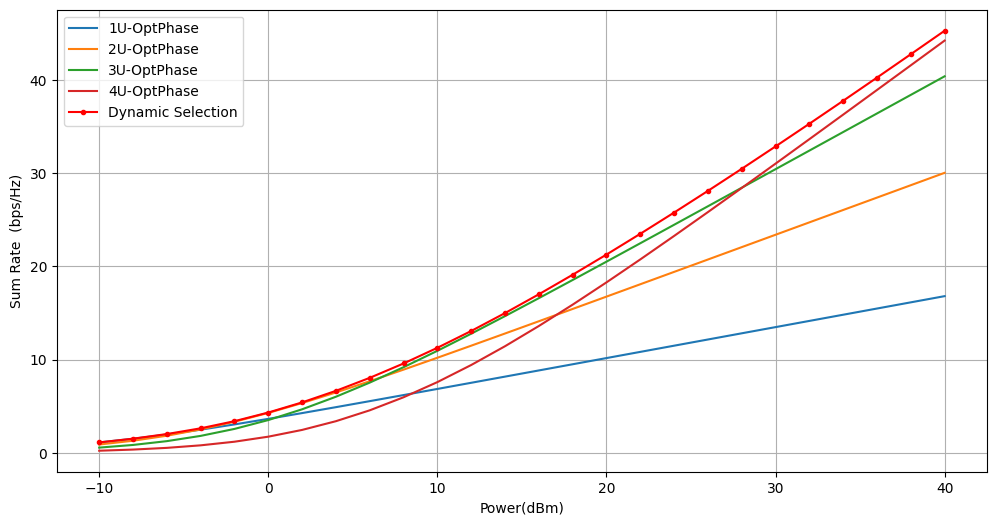

In [12]:
plt.figure(figsize=(12,6))
plt.plot(power_dBm, list_1,label='1U-OptPhase')
plt.plot(power_dBm, list_2, label='2U-OptPhase')
plt.plot(power_dBm, list_3, label='3U-OptPhase')
plt.plot(power_dBm, list_4, label='4U-OptPhase')
#plt.plot(power_dBm, list_wmmse2, marker='*',label='2 users mmse')
#plt.plot(power_dBm, list_wmmse3, marker='s',label='3 users mmse')
plt.plot(power_dBm, DR_mean, marker='.',label='Dynamic Selection',color='red')
plt.xlabel('Power(dBm)')
plt.ylabel('Sum Rate  (bps/Hz)')
plt.grid()
plt.legend()
plt.savefig("s2_fig3(thesis)", dpi=1200, bbox_inches="tight")
plt.show()


PLots

In [13]:
print(list_1 )
print(list_1_rnd2)
print(rate_w1)

[ 1.1129578   1.50352921  1.96278751  2.48015758  3.04297224  3.6391425
  4.25864892  4.89392895  5.53962034  6.19207514  6.84887784  7.50845674
  8.16980061  8.83226344  9.49543444 10.15905312 10.8229546  11.48703466
 12.15122745 12.81549139 13.47980022 14.14413739 14.80849244 15.47285877
 16.13723222 16.80161016]
[0.22841426 0.30240728 0.43384093 0.51668032 0.66116943 0.9262925
 0.97516435 1.15174956 1.34734809 1.51467836 1.62288986 1.79979507
 1.90689795 2.24823945 2.25000909 2.39817294 2.73942831 2.6776525
 3.15043065 3.04677502 3.53780151 3.27523924 3.80596103 3.84926968
 3.78313727 3.58386288]
[ 0.22632148  0.32199223  0.45522936  0.66702186  0.93334193  1.20646873
  1.61558031  2.02108812  2.57801476  3.04159511  3.65685809  4.24712316
  4.88961899  5.48161367  6.19370319  6.82958261  7.47798353  8.14429878
  8.77079874  9.48093156 10.16577659 10.7303837  11.45498069 12.11711516
 12.74398531 13.44019104]


In [14]:
print(list_3)
print(rate_w3)
print(list_8)

[ 0.55581942  0.84125428  1.2495386   1.81325209  2.56080033  3.51025041
  4.66485875  6.01229071  7.5278868   9.18042741 10.93800877 12.77223818
 14.66021714 16.58475817 18.53361539 20.49838286 22.4734404  24.45509915
 26.44096893 28.42951479 30.41975697 32.41107266 34.40306696 36.39548994
 38.38818362 40.38104818]
[ 0.49305489  0.75117914  1.12501666  1.64848289  2.35287077  3.26001694
  4.37667565  5.69275401  7.18425478  8.81936155 10.56491512 12.39113715
 14.27391935 16.19514533 18.14191029 20.10536449 22.07959921 24.06074226
 26.0462884  28.03463088 30.02474511 32.0159802  34.00792371 36.00031468
 37.99298817 39.98583999]
[ 0.49010593  0.74673084  1.11845799  1.63909939  2.33993634  3.24293322
  4.35510965  5.66671091  7.15405519  8.78554444 10.52811573 12.35198372
 14.23297058 16.15286647 18.09867262 20.06145414 22.0352289  24.01606437
 26.00140846 27.98961996 29.97965004 31.97083143 33.9627408  35.95511013
 37.94776992 39.94061308]


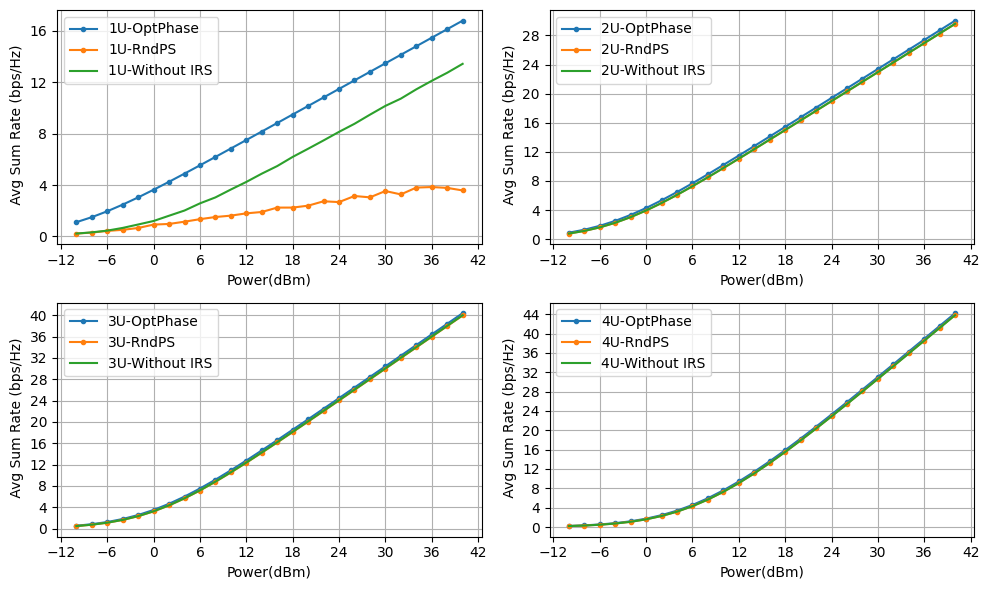

In [15]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(10,6))
x=6
y=4
plt.subplot(2, 2, 1)  # 2x2 grid, first subplot
plt.plot(power_dBm, list_1, marker='.',label='1U-OptPhase')
#plt.plot(power_dBm, list_1_rnd, marker='.',label='1 user but Rnd PS')
plt.plot(power_dBm, list_1_rnd2, marker='.',label='1U-RndPS')
plt.plot(power_dBm,rate_w1, label='1U-Without IRS')
# 
# 
# 
plt.xlabel('Power(dBm)')
plt.ylabel(' Avg Sum Rate (bps/Hz)')
plt.gca().xaxis.set_major_locator(MultipleLocator(x))
plt.gca().yaxis.set_major_locator(MultipleLocator(y))
plt.grid()
plt.legend()

plt.subplot(2, 2, 2)  # 2x2 grid, second subplot
plt.plot(power_dBm, list_2, marker='.',label='2U-OptPhase')
plt.plot(power_dBm, list_7, marker='.',label='2U-RndPS')
plt.plot(power_dBm,rate_w2, label='2U-Without IRS')
plt.xlabel('Power(dBm)')
plt.ylabel(' Avg Sum Rate (bps/Hz)')
plt.gca().xaxis.set_major_locator(MultipleLocator(x))
plt.gca().yaxis.set_major_locator(MultipleLocator(y))
plt.grid()
plt.legend()
plt.subplot(2, 2, 3)  # 2x2 grid, third subplot
plt.plot(power_dBm, list_3, marker='.',label='3U-OptPhase')
plt.plot(power_dBm, list_8, marker='.',label='3U-RndPS')
plt.plot(power_dBm,rate_w3, label='3U-Without IRS')
plt.xlabel('Power(dBm)')
plt.ylabel(' Avg Sum Rate (bps/Hz)')
plt.gca().xaxis.set_major_locator(MultipleLocator(x))
plt.gca().yaxis.set_major_locator(MultipleLocator(y))
plt.grid()
plt.legend()
plt.subplot(2, 2, 4)  # 2x2 grid, fourth subplot
plt.plot(power_dBm, list_4, marker='.',label='4U-OptPhase')
plt.plot(power_dBm, list_5, marker='.',label='4U-RndPS')
plt.plot(power_dBm,rate_w4, label='4U-Without IRS')
plt.grid()
plt.xlabel('Power(dBm)')
plt.ylabel(' Avg Sum Rate (bps/Hz)')
plt.gca().xaxis.set_major_locator(MultipleLocator(x))
plt.gca().yaxis.set_major_locator(MultipleLocator(y))
plt.grid()
plt.legend()
plt.tight_layout()





plt.xlabel('Power(dBm)')
plt.ylabel(' Avg Sum Rate (bps/Hz)')
plt.gca().xaxis.set_major_locator(MultipleLocator(x))
plt.gca().yaxis.set_major_locator(MultipleLocator(y))
plt.grid()
plt.legend()

plt.savefig("s2fig1(thesis)", dpi=1200, bbox_inches="tight")
plt.show()

comparing user selection with all users

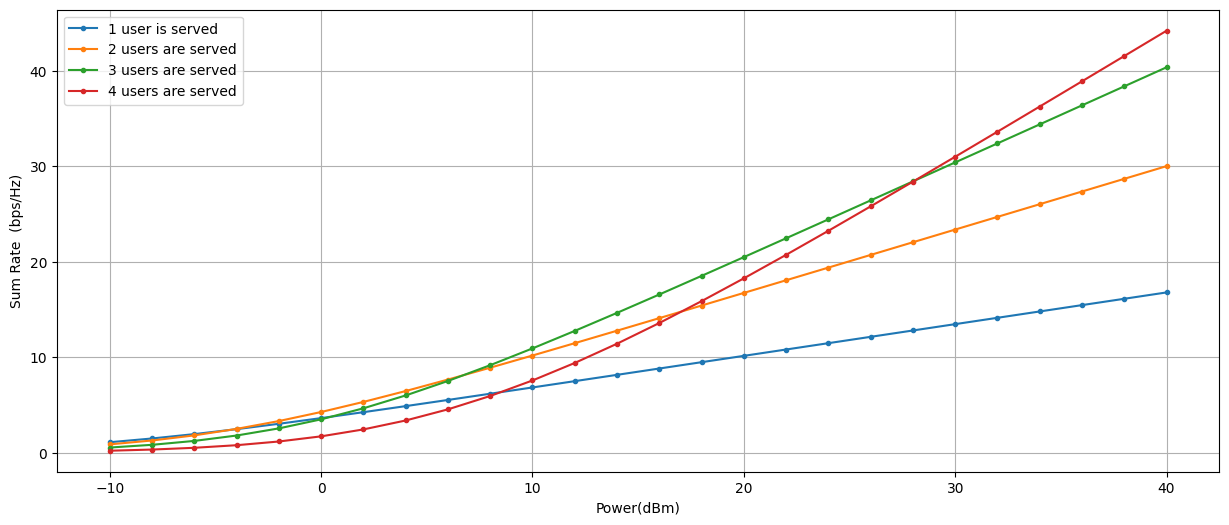

In [16]:
plt.figure(figsize=(15,6))
plt.plot(power_dBm, list_1, marker='.',label='1 user is served')
plt.plot(power_dBm, list_2, marker='.',label='2 users are served')
plt.plot(power_dBm, list_3, marker='.',label='3 users are served')
plt.plot(power_dBm, list_4, marker='.',label='4 users are served')

plt.xlabel('Power(dBm)')
plt.ylabel('Sum Rate  (bps/Hz)')
plt.grid()
plt.legend()
plt.savefig("s2_f2(thesis)", dpi=1200, bbox_inches="tight")
plt.show()


In [17]:
dpc_rate = [

    0.3549,
    2.2219,
    6.8159,
   15.2039,
   27.0975,
   40.1291,
   53.3769,
   66.6589,
   79.9476,
   93.2361,
  106.5224,
  119.8106


]


In [18]:
print("list_bcd",list_bcd)

list_bcd [ 1.11576559  1.52201031  2.03255897  2.67387534  3.46462851  4.40292416
  5.48461109  6.72334488  8.10729426  9.64013868 11.30542442 13.09381286
 15.00046258 17.00683874 19.09707619 21.26149276 23.48802225 25.76584575
 28.09118883 30.4571071  32.85890531 35.29237568 37.7547683  40.24128936
 42.74759293 45.26950928]


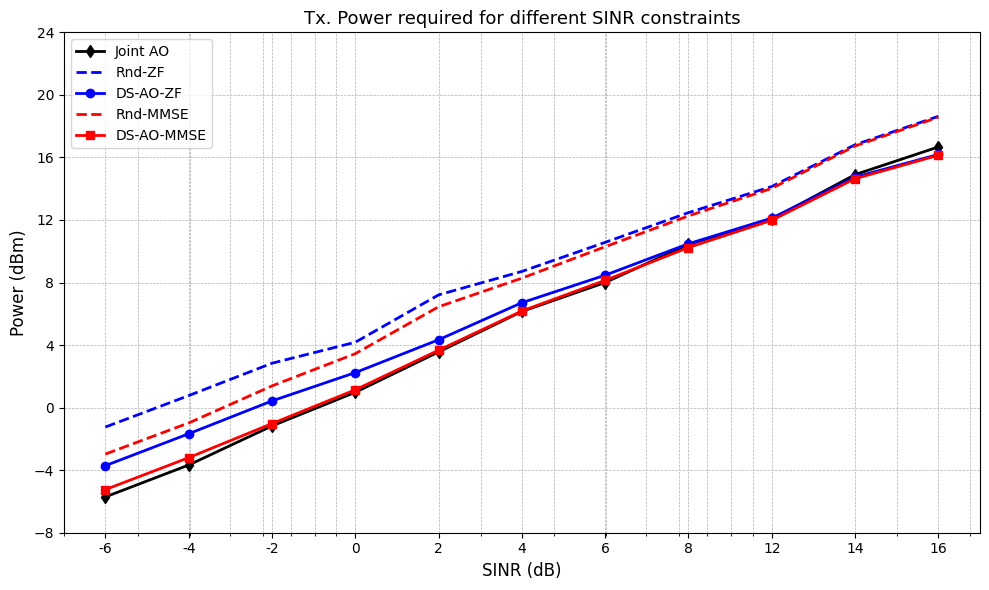

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# SINR values (log scale) and x-axis tick labels
x = np.array([0.25118864, 0.39810717, 0.63095734, 1, 1.58489319, 2.51188643,
              3.98107171, 6.30957344, 10, 15.84893192, 25.11886432])
xticks = x
xtick_labels = ['-6', '-4', '-2', '0', '2', '4', '6', '8', '12', '14', '16']

# Define power values for different schemes
joint_ao = [-5.71, -3.67, -1.17, 0.98, 3.56, 6.15, 8.00, 10.44, 12.05, 14.90, 16.67]
zf_rnd = [-1.24, 0.77, 2.84, 4.18, 7.21, 8.71, 10.57, 12.47, 14.14, 16.81, 18.63]
zf_dyn = [-3.71, -1.67, 0.43, 2.24, 4.34, 6.71, 8.47, 10.48, 12.12, 14.74, 16.19]
socp_rnd = [-2.97, -0.98, 1.39, 3.45, 6.45, 8.28, 10.29, 12.26, 14.02, 16.73, 18.57]
socp_dyn = [-5.24, -3.20, -1.02, 1.14, 3.67, 6.18, 8.14, 10.24, 11.98, 14.64, 16.14]

# Plotting
plt.figure(figsize=(10, 6))
plt.xscale("log")

plt.plot(x, joint_ao, 'k-d', label="Joint AO", linewidth=2)
plt.plot(x, zf_rnd, 'b--', label="Rnd-ZF", linewidth=2)
plt.plot(x, zf_dyn, 'b-o', label="DS-AO-ZF", linewidth=2)
plt.plot(x, socp_rnd, 'r--', label="Rnd-MMSE", linewidth=2)
plt.plot(x, socp_dyn, 'r-s', label="DS-AO-MMSE", linewidth=2)

plt.xticks(xticks, xtick_labels)
plt.yticks(np.arange(-8, 26, 4))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("SINR (dB)", fontsize=12)
plt.ylabel("Power (dBm)", fontsize=12)
plt.legend(loc='upper left')
plt.title("Tx. Power required for different SINR constraints", fontsize=13)

# Save figure as high-DPI image
plt.tight_layout()
plt.savefig("TXP.png", dpi=1200)
plt.show()


In [20]:
import matplotlib.pyplot as plt

# Coordinates
bs = (100, 0)
irs = (0, 0)
user_area = [(10, 10), (20, 10), (20, 20), (10, 20)]
users = [(12, 12), (18, 11), (15, 19), (13, 15)]  # Example positions of 4 users

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6), dpi=1200)
#ax.set_title(" IRS-Aided Downlink (ProbWSR)", fontsize=16)
ax.set_xlabel("X-axis (m)")
ax.set_ylabel("Y-axis (m)")
ax.grid(True, linestyle='--', alpha=0.5)

# Plot base station and IRS
ax.scatter(*bs, c='blue', label='BS', s=200)
ax.scatter(*irs, c='green', label='IRS (10×10)', s=200)

# Draw user area rectangle
user_rect = plt.Polygon(user_area, closed=True, fill=False, edgecolor='gray', linestyle='--', label='User Region')
ax.add_patch(user_rect)

# Plot user locations
ux, uy = zip(*users)
ax.scatter(ux, uy, c='red', label='Users (K=4)', s=80, marker='x')

# Annotate points
ax.annotate("BS", bs, textcoords="offset points", xytext=(0,10), ha='center')
ax.annotate("IRS", irs, textcoords="offset points", xytext=(0,10), ha='center')
for i, (x, y) in enumerate(users, 1):
    ax.annotate(f"U{i}", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Set plot limits and legend
ax.set_xlim(-10, 110)
ax.set_ylim(-10, 30)
ax.legend(loc='upper right', fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig("locationwsr.png")
plt.show()


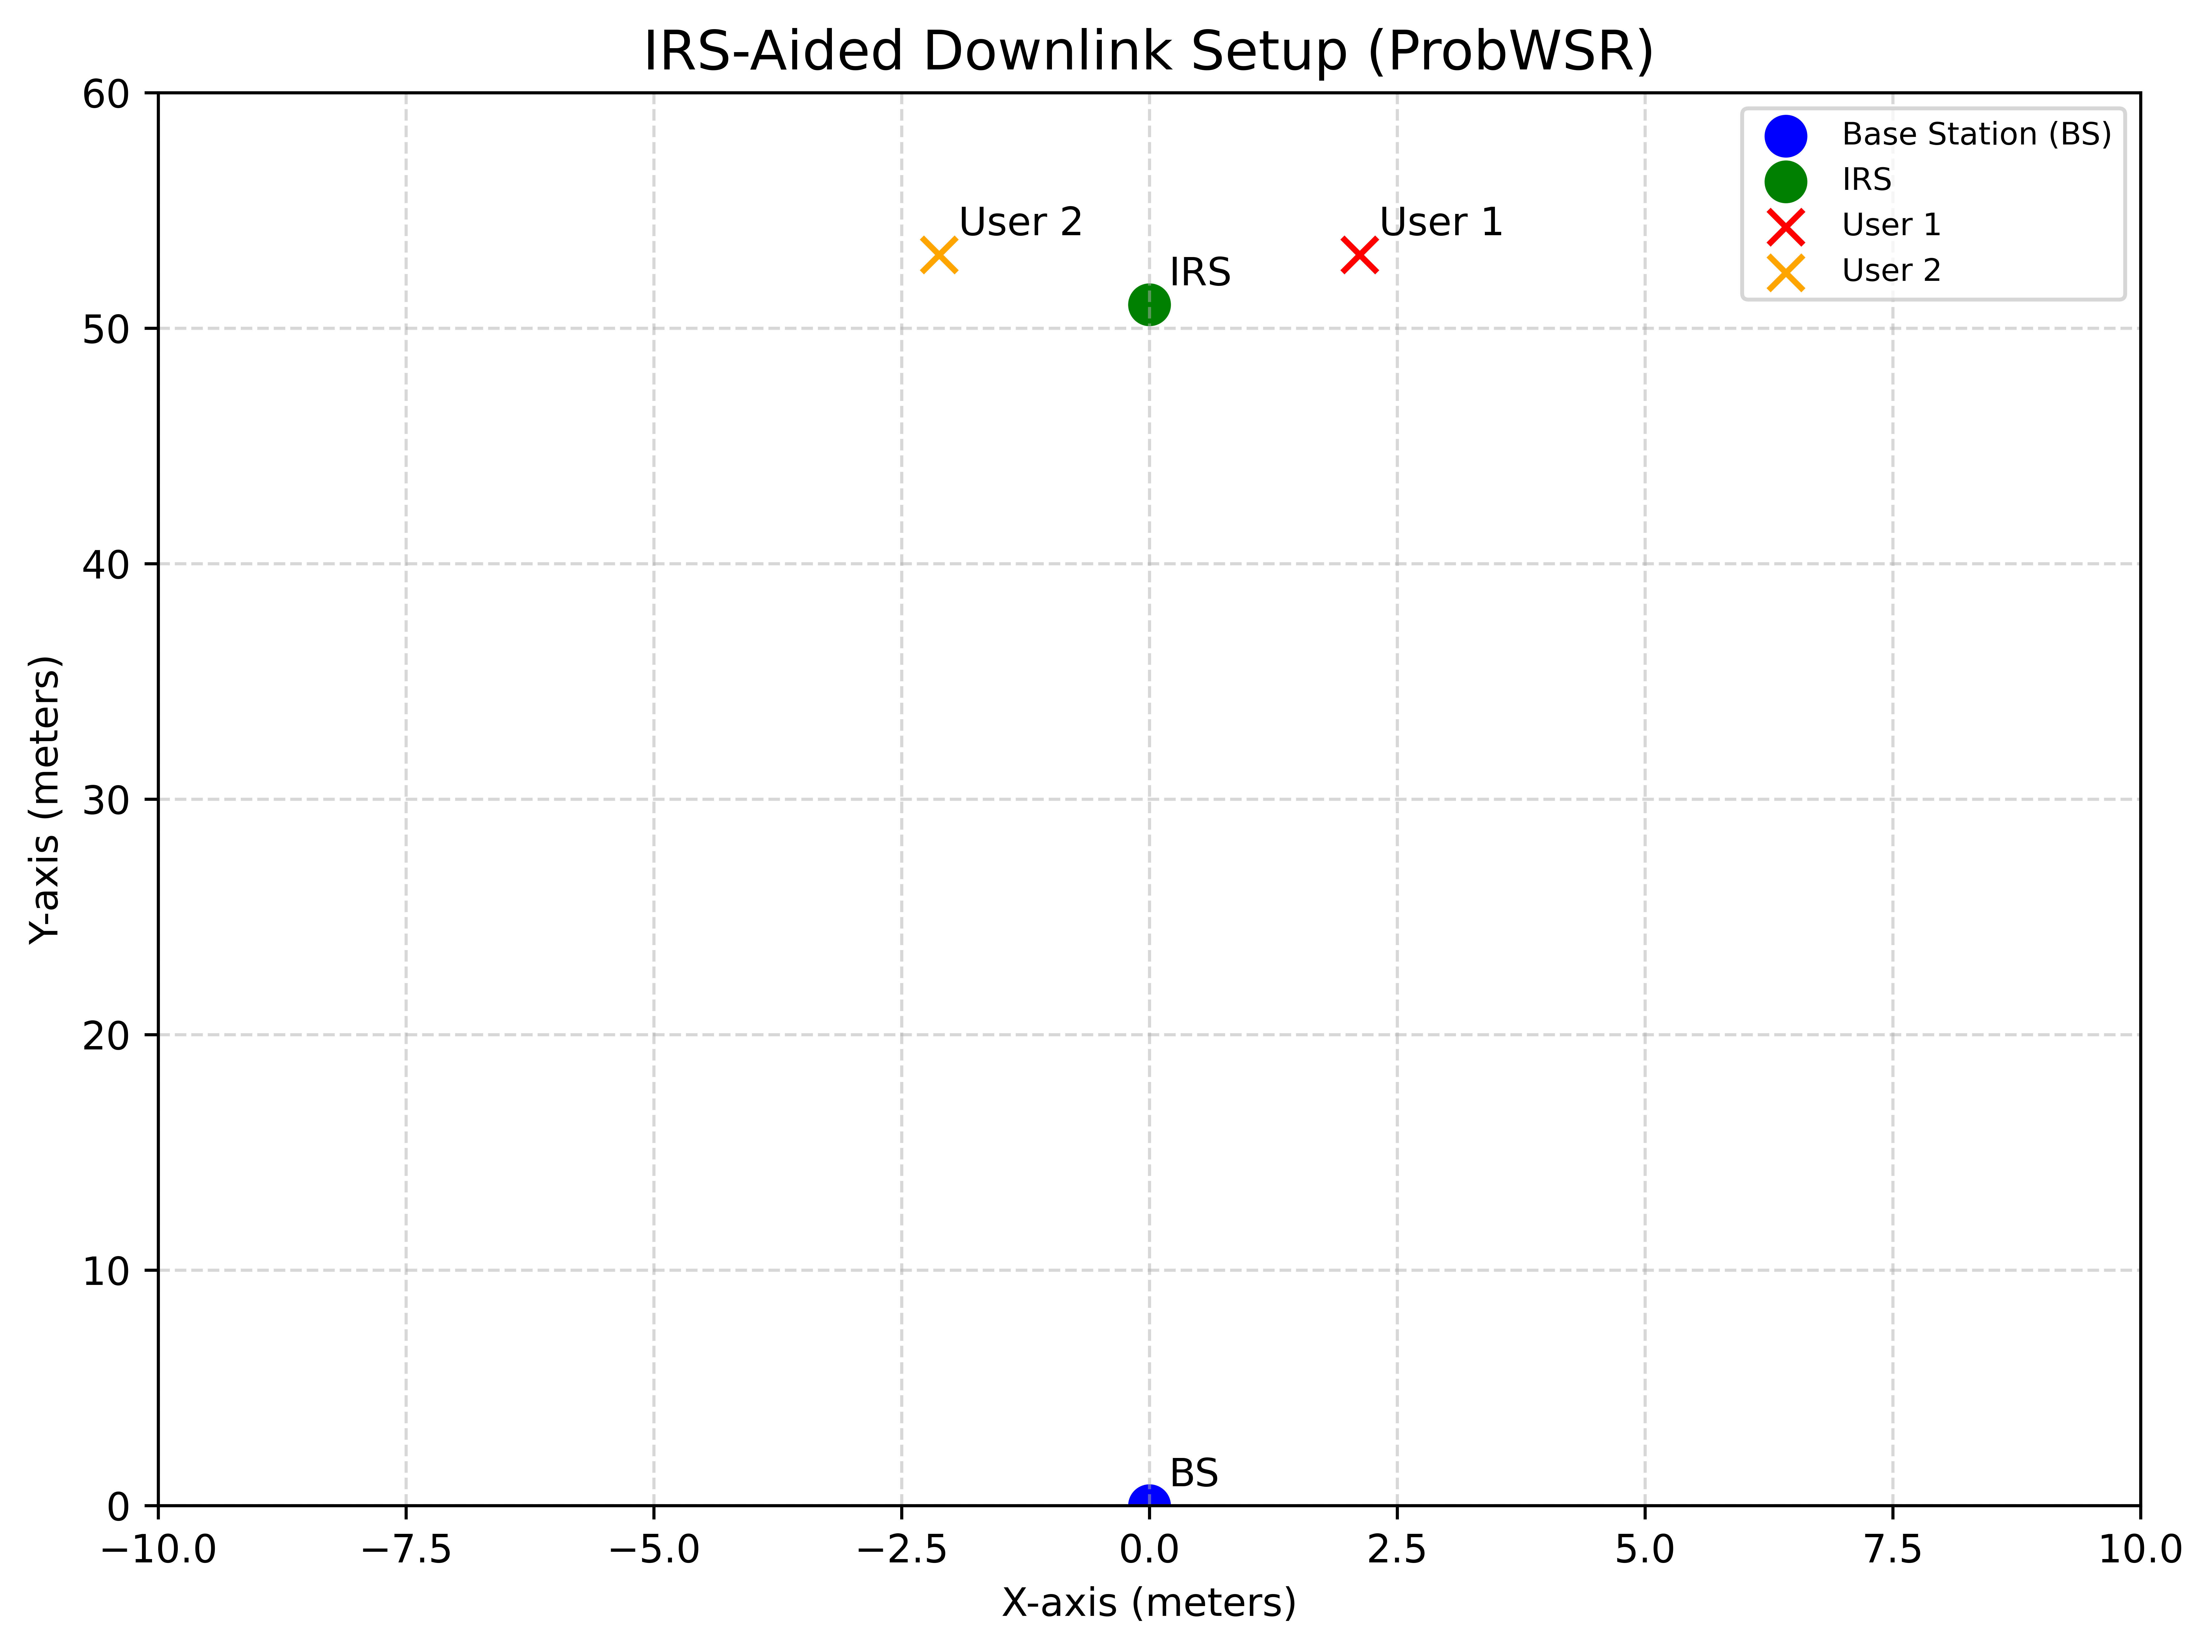

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define positions
d0 = 51  # Distance between BS and IRS along y-axis
r = 3    # Distance of users from IRS
angle_rad = np.deg2rad(45)

# Coordinates
bs = (0, 0)
irs = (0, d0)
user1 = (r * np.cos(angle_rad), d0 + r * np.sin(angle_rad))
user2 = (-r * np.cos(angle_rad), d0 + r * np.sin(angle_rad))

# Plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=1000)
ax.set_title("IRS-Aided Downlink Setup (ProbWSR)", fontsize=14)
ax.set_xlabel("X-axis (meters)")
ax.set_ylabel("Y-axis (meters)")
ax.grid(True, linestyle='--', alpha=0.5)

# Plot BS, IRS, and Users
ax.scatter(*bs, color='blue', label='Base Station (BS)', s=100)
ax.scatter(*irs, color='green', label='IRS', s=100)
ax.scatter(*user1, color='red', label='User 1', marker='x', s=80)
ax.scatter(*user2, color='orange', label='User 2', marker='x', s=80)

# Annotate positions
ax.annotate("BS", bs, textcoords="offset points", xytext=(5,5), ha='left')
ax.annotate("IRS", irs, textcoords="offset points", xytext=(5,5), ha='left')
ax.annotate("User 1", user1, textcoords="offset points", xytext=(5,5), ha='left')
ax.annotate("User 2", user2, textcoords="offset points", xytext=(5,5), ha='left')

# Axes limits and legend
ax.set_xlim(-10, 10)
ax.set_ylim(0, 60)
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()

# Save figure
plt.savefig("irs_user_geometry_high_dpi.png")
plt.show()


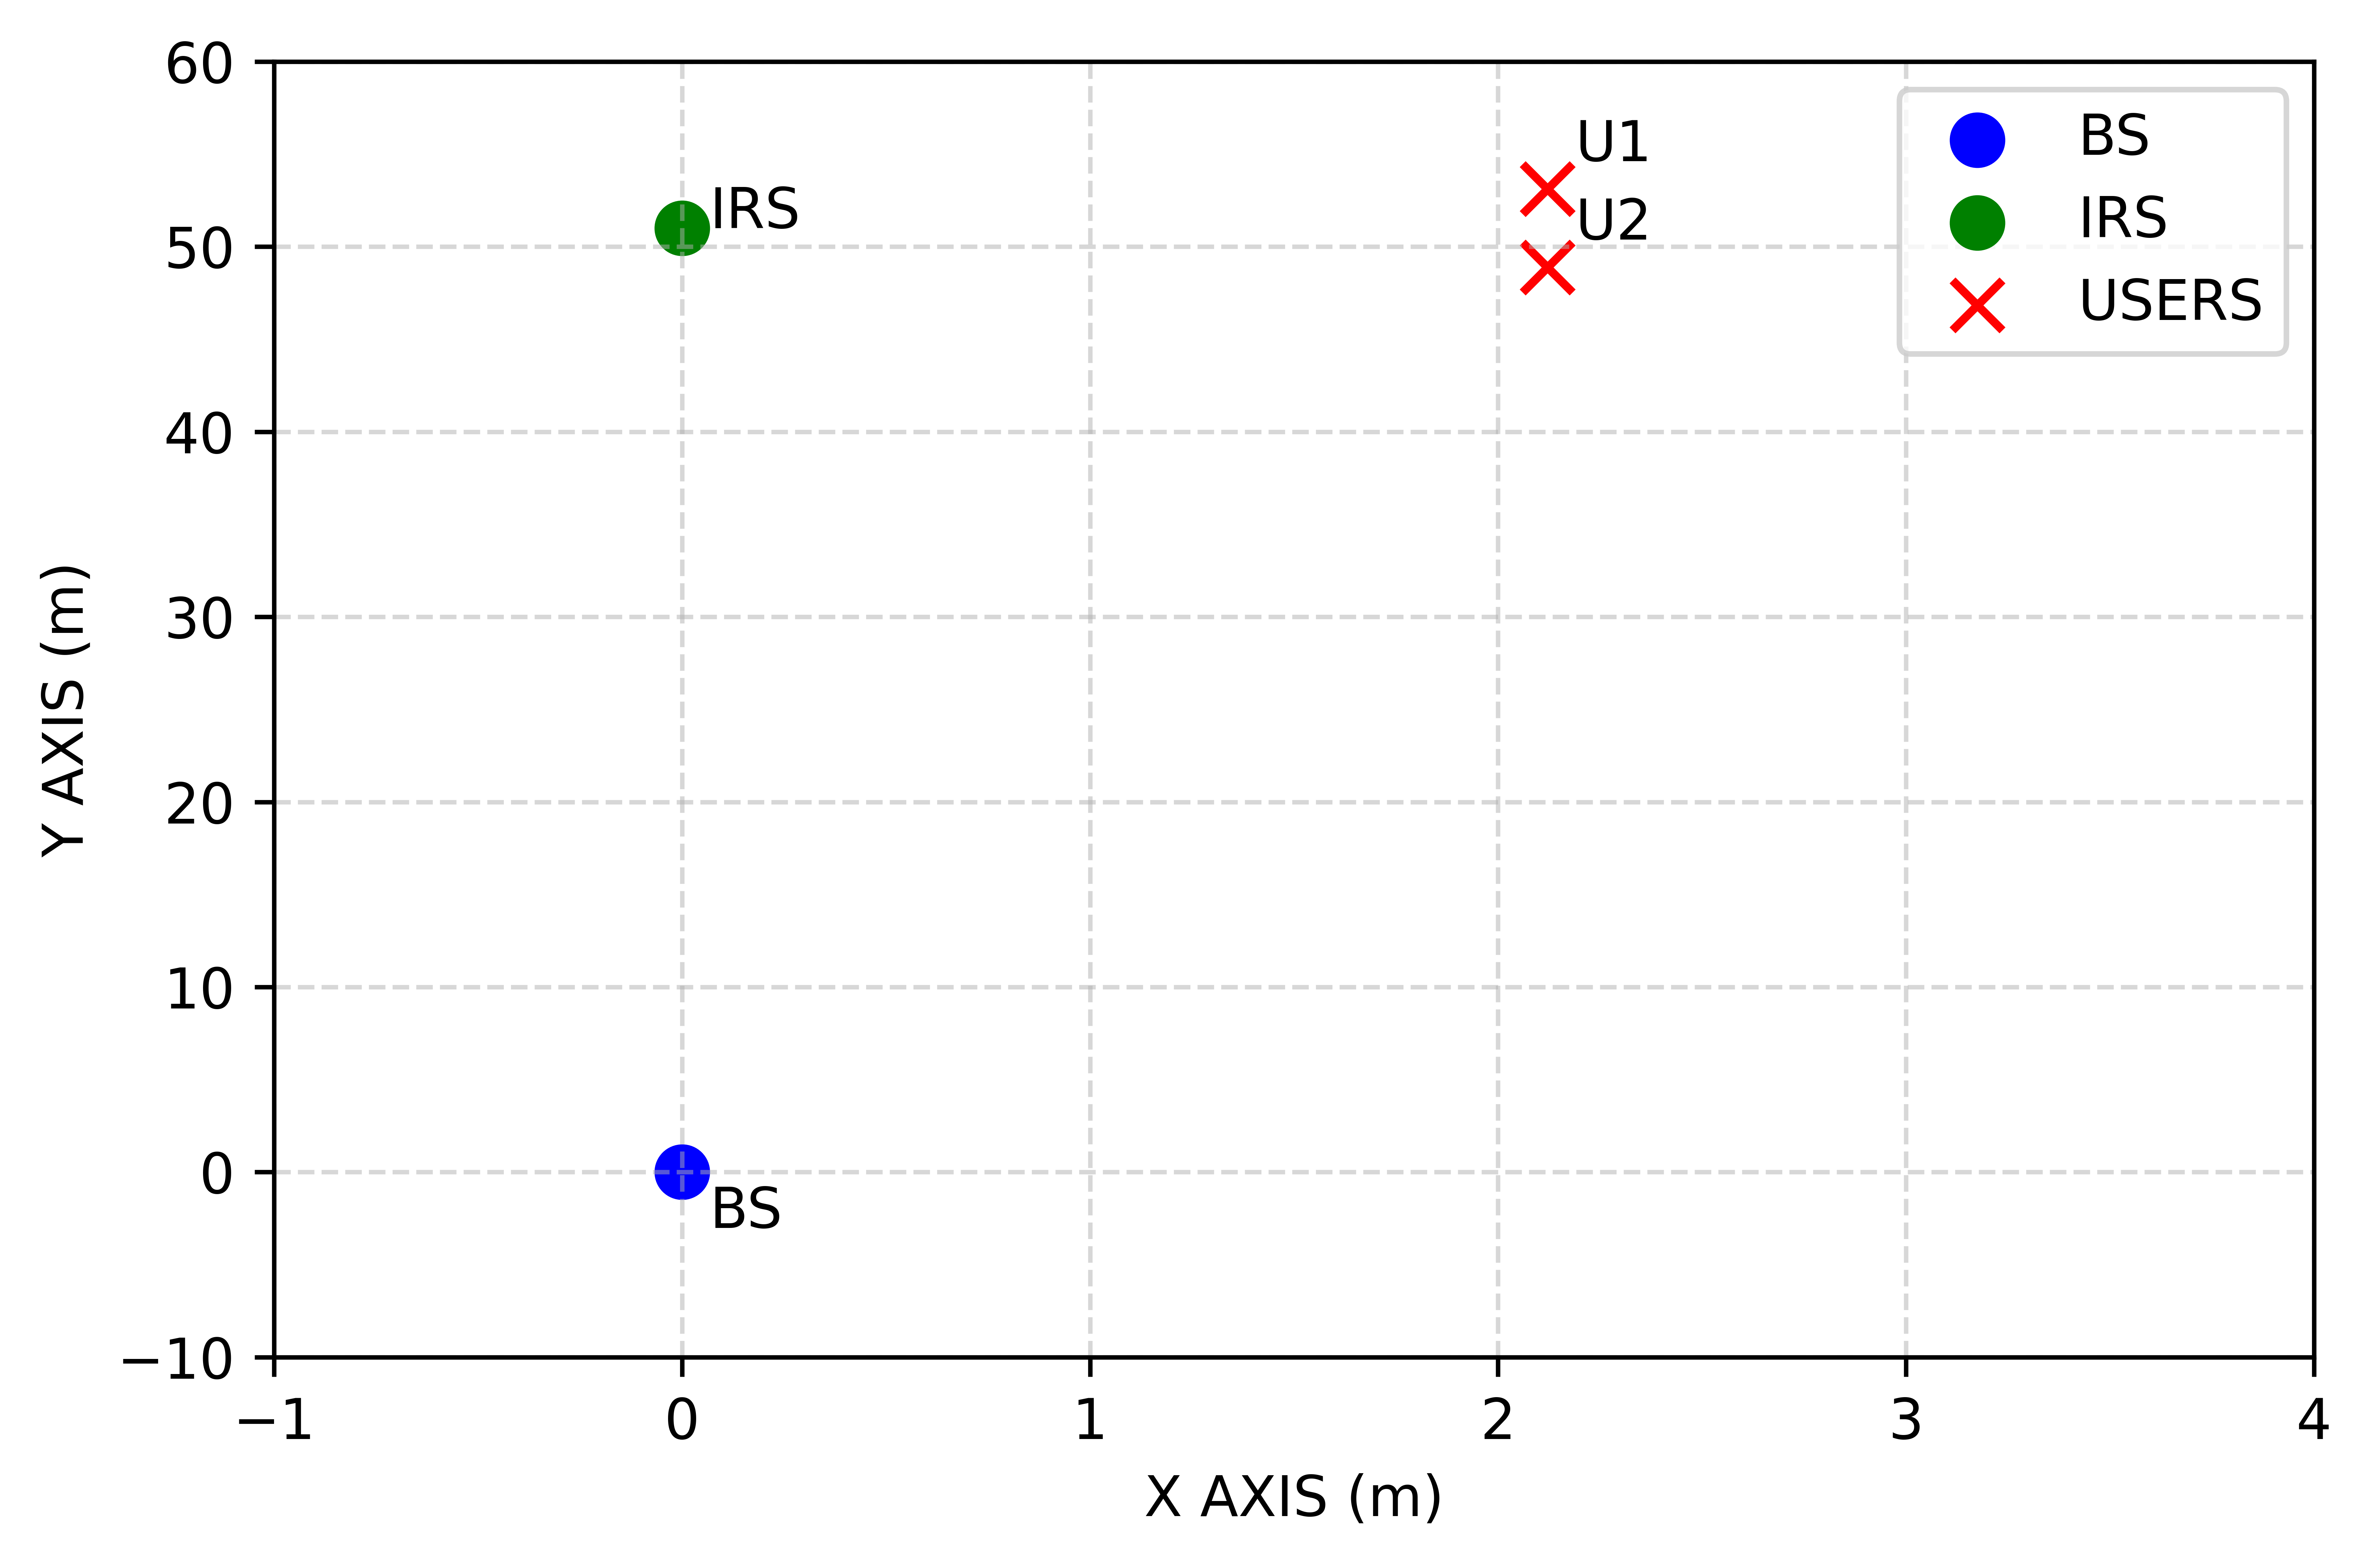

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Coordinates
bs = (0, 0)
irs = (0, 51)

# Compute user positions at 45 degrees, 3 meters from IRS
distance = 3
angle_rad = np.radians(45)
ux1 = irs[0] + distance * np.cos(angle_rad)
uy1 = irs[1] + distance * np.sin(angle_rad)

ux2 = irs[0] + distance * np.cos(angle_rad)
uy2 = irs[1] - distance * np.sin(angle_rad)

users = [(ux1, uy1), (ux2, uy2)]

# Plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=1200)
#ax.set_title(" IRS-Aided System (ProbWSR)", fontsize=14)
ax.set_xlabel("X AXIS (m)")
ax.set_ylabel("Y AXIS (m)")
ax.grid(True, linestyle='--', alpha=0.5)

# Plot points
ax.scatter(*bs, c='blue', label='BS', s=80)
ax.scatter(*irs, c='green', label='IRS', s=80)
ux, uy = zip(*users)
ax.scatter(ux, uy, c='red', label='USERS', s=80, marker='x')

# Annotate
ax.annotate("BS", bs, textcoords="offset points", xytext=(5,-10), ha='left')
ax.annotate("IRS", irs, textcoords="offset points", xytext=(5,0), ha='left')
for i, (x, y) in enumerate(users, 1):
    ax.annotate(f"U{i}", (x, y), textcoords="offset points", xytext=(5, 5), ha='left')

# Set plot limits
ax.set_xlim(-1, 4)
ax.set_ylim(-10, 60)
ax.legend()
plt.tight_layout()
plt.savefig("location_txp.png")
plt.show()


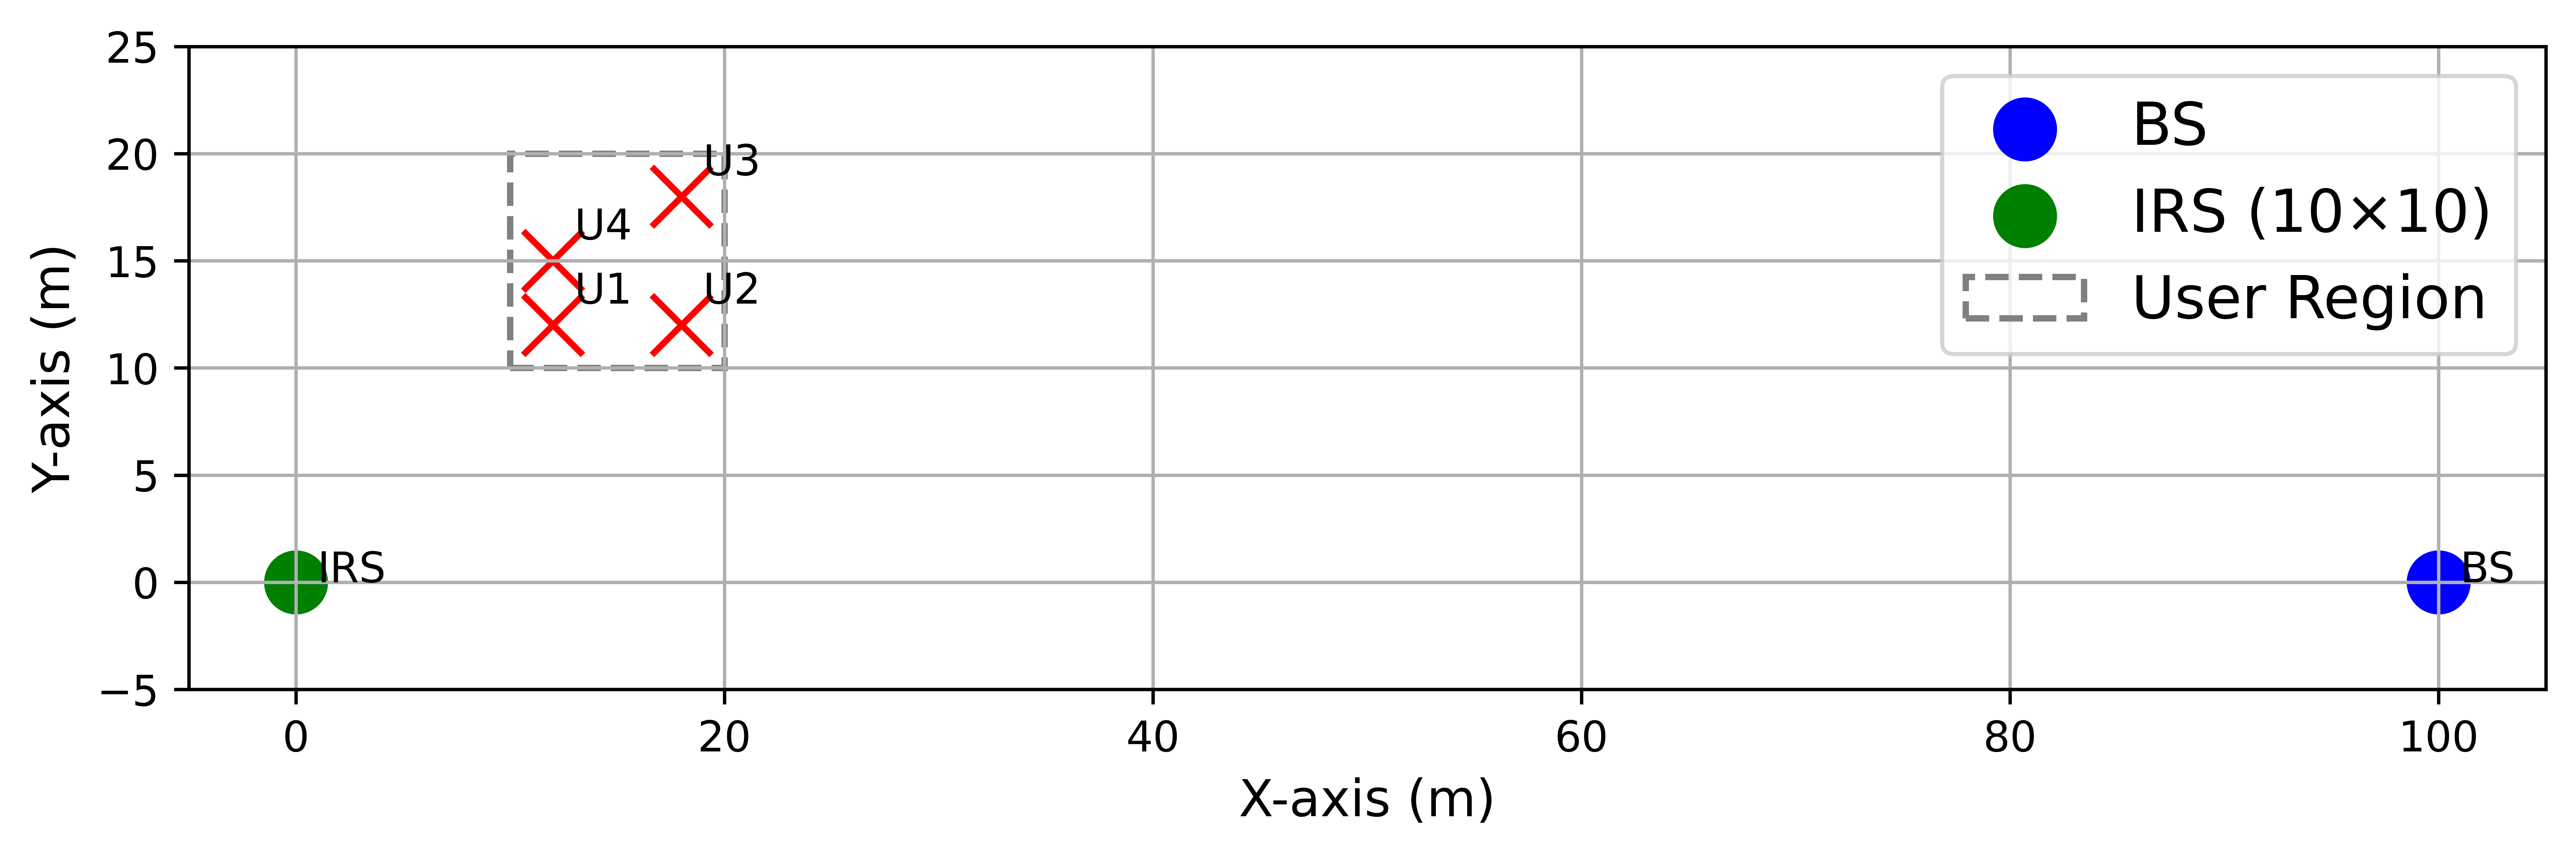

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Coordinates
bs_coords = (100, 0)
irs_coords = (0, 0)
user_coords = [(12, 12), (18, 12), (18, 18), (12, 15)]  # You can adjust user locations here

# Create the plot
fig, ax = plt.subplots(figsize=(10, 12), dpi=1000)

# Plot Base Station
ax.scatter(*bs_coords, color='blue', s=200, label='BS')
ax.text(bs_coords[0]+1, bs_coords[1], 'BS', fontsize=10)

# Plot IRS
ax.scatter(*irs_coords, color='green', s=200, label='IRS (10×10)')
ax.text(irs_coords[0]+1, irs_coords[1], 'IRS', fontsize=10)

# Plot Users
for i, (x, y) in enumerate(user_coords):
    ax.scatter(x, y, color='red', marker='x', s=200)
    ax.text(x+1, y+1, f'U{i+1}', fontsize=10)

# Draw user region rectangle
user_region = patches.Rectangle((10, 10), 10, 10, linewidth=1.5, edgecolor='gray',
                                linestyle='--', facecolor='none', label='User Region')
ax.add_patch(user_region)

# Labels and legend
#ax.set_title('2D Top-Down View of IRS-Aided Downlink Setup', fontsize=15)
ax.set_xlabel('X-axis (m)', fontsize=12)
ax.set_ylabel('Y-axis (m)', fontsize=12)
ax.legend( fontsize=14)
ax.grid(True)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 25)
ax.set_aspect('equal')

plt.show()


In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Coordinates
bs_coords = (100, 0)
irs_coords = (0, 0)
user_coords = [(12, 12), (18, 12), (18, 18), (12, 15)]  # User locations

# Create the plot with increased height
fig, ax = plt.subplots(figsize=(12, 8), dpi=1200)

# Plot Base Station
ax.scatter(*bs_coords, color='blue', s=200, label='Base Station (BS)')
ax.text(bs_coords[0]+1, bs_coords[1], 'BS', fontsize=12, fontweight='bold')

# Plot IRS
ax.scatter(*irs_coords, color='green', s=200, label='IRS (10×10)')
ax.text(irs_coords[0]+1, irs_coords[1], 'IRS', fontsize=12, fontweight='bold')

# Plot Users
for i, (x, y) in enumerate(user_coords):
    ax.scatter(x, y, color='red', marker='x', s=200)
    ax.text(x+1, y+1, f'U{i+1}', fontsize=12)

# Draw user region rectangle
user_region = patches.Rectangle((10, 10), 10, 10, linewidth=2, edgecolor='gray',
                                linestyle='--', facecolor='none', label='User Region')
ax.add_patch(user_region)

# Labels and legend
ax.set_xlabel('X-axis (m)', fontsize=14)
ax.set_ylabel('Y-axis (m)', fontsize=14)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, linestyle='--', alpha=1)

# Axis limits and spacing
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 25)
ax.set_yticks(range(-5, 26, 5))  # 5-meter grid spacing
ax.set_xticks(range(0, 106, 10))  # 10-meter grid spacing
# Equal aspect ratio for consistent scaling
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

